# Movie review sentiment prediction

Film Junky Union needs an ML model to filter negative reviews. To train the model, we were given a set of labeled IMDB reviews. The model needs to have an F1 score of at least 0.85. 

Two major stages of this project are:
1. Text preprocessing, 
1. Machine learning.

Dataset description:
- `review`: review text
- `pos`: target (`0` for negative reviews and `1` for positive reviews)
- `ds_part`: training/test set separation

## Loading libraries

In [16]:
# For dataframe manipulation
import pandas as pd

# For numerical operations
import numpy as np

# Regex
import re

# nltk
from nltk.corpus import stopwords
## Downloading resource, skip if available
# from nltk import download as nltkdownload
# nltkdownload('stopwords')

# spaCy
import spacy

# sklearn
## Text processing
from sklearn.feature_extraction.text import TfidfVectorizer

## Metrics
from sklearn.metrics import (make_scorer, 
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             average_precision_score,
                             precision_recall_curve,
                             accuracy_score)

## Cross-validator
from sklearn.model_selection import cross_val_score

## Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# XGBoost
from xgboost import XGBClassifier

# LightGBM
from lightgbm import LGBMClassifier

# For hyperparameter optimization
import optuna

# For data visualization
import matplotlib.pyplot as plt

# Setting random state value
random_state = 42

print('Loading complete.')

Loading complete.


## Loading data

In [17]:
# If run locally
try:
    df = pd.read_csv('dataset/imdb_reviews.tsv', sep='\t')
    df.head()

# If run on the platform
except:
    df = pd.read_csv(r'\dataset\imdb_reviews.tsv', sep='\t')
    df.head()

Most of the features are not relevant for this task, so we will drop them.

In [18]:
# Getting only relevant columns
df = df[['review', 'pos', 'ds_part']]

In [19]:
# Getting general information of the set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   review   47331 non-null  object
 1   pos      47331 non-null  int64 
 2   ds_part  47331 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


None of the rows have missing values.

In [20]:
# Checking for duplicates
df.duplicated().sum()

90

90 rows are duplicates. We will drop them.

In [21]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

# Checking for duplicates
df.duplicated().sum()

0

## EDA

In [22]:
# Checking for class imbalance
df['pos'].value_counts()

pos
0    23680
1    23561
Name: count, dtype: int64

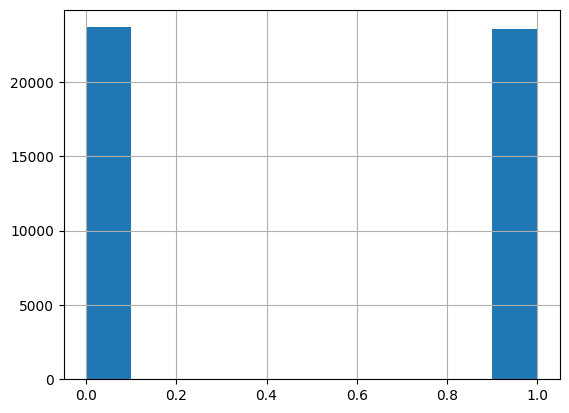

In [23]:
# Checking for class imbalance
df['pos'].hist()
plt.show()

The number of positive and negative reviews are balanced.

In [24]:
# Checking for class imbalance
df['ds_part'].value_counts()

ds_part
train    23758
test     23483
Name: count, dtype: int64

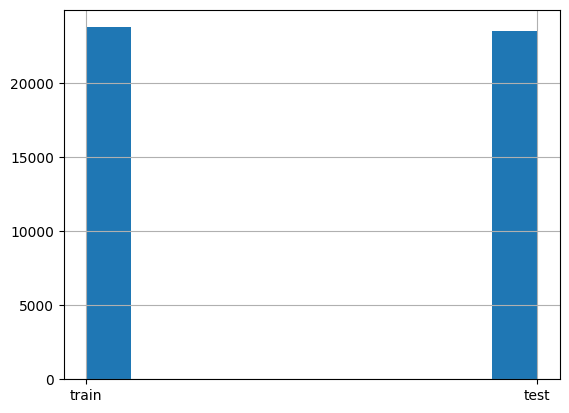

In [25]:
# Checking for class imbalance
df['ds_part'].hist()
plt.show()

The number of training/test data are also roughly equal.

## Data preprocessing

Text data need to be processed before it can be used by ML models. First, we need to normalize the data: removing captialization, punctuation, numbers and symbols. Next, using spaCy, we will turn the dataframe into corpora of lemmas for use as ML features. Finally, 

### Normalization

We will extract words by using regex, removing everything except words and spaces between them.

In [26]:
# # Removing non-letter and non-whitespace characters except apostrophes,
# # and converting them to lowercase letters
df['review_normal'] = df['review'].apply(lambda row: re.sub('[^a-zA-Z\s\']', ' ', row).lower())

# # Removing excess whitespace
# # and rejoining words with single whitespaces
df['review_normal'] = df['review_normal'].apply(lambda row: ' '.join(row.split()))

df['review_normal'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_normal, dtype: object

### Set separation

Because we need separate corpora for training and testing, we will split our dataframe into two prior to text processing. The set original set has already indicated to which set does each row belong to, so we can separate the set by using the values in `ds_part`.

In [27]:
df_train = df.query('ds_part == "train"').copy()
df_test = df.query('ds_part == "test"').copy()

train_target = df_train['pos']
test_target = df_test['pos']

# Checking set completeness
print(len(df_train) + len(df_test) == len(df))
print(len(train_target) + len(test_target) == len(df))

True
True


## Text preprocessing

### Tokenization and lemmatization with spaCy

In this stage, we will separate each word in the review and reduce it to lemmas.

In [28]:
# Creating an instance of spacy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
# Defining a function to process reviews with spacy
def spacy_reviews(text):
  # Getting text
  doc = nlp(text)
  # Getting tokens if they're not stop words,
  # getting their lemma forms, and storing them in a list
  lemmas = [token.lemma_ for token in doc if not token.is_stop]

  return ' '.join(lemmas)

In [30]:
# # Cell commented--use .csv file to save time
# # Creating empty corpus list
# corpus_train = None

# # Creating training corpus
# corpus_train = df_train['review_normal'].apply(
#         lambda row: spacy_reviews(text=row)
#         )

# corpus_train

In [31]:
# # Saving the result of previous cell in a .csv file to save time
# corpus_train.to_csv(path_or_buf='dataset/corpus_train.csv')

In [32]:
# Loading data
corpus_train = pd.read_csv('dataset/corpus_train.csv')
corpus_train = corpus_train['review_normal']

# Removing non-possesive apostrophes
corpus_train = corpus_train.apply(lambda row: re.sub("\s\'\s", " ", row))
corpus_train.head()

0    pakage imply warren beatty goldie hawn pull hu...
1    hell present caper comedy misbegotten essentia...
2    true story carlson raider army training film o...
3    title balderdash little film true island fact ...
4    movie gung ho story carlson makin island raide...
Name: review_normal, dtype: object

In [33]:
# # Cell commented--use .csv file to save time
# # Creating empty corpus list
# corpus_test = None

# # Creating training corpus
# corpus_test = df_test['review_normal'].apply(
#         lambda row: spacy_reviews(text=row)
#         )

# corpus_test

In [34]:
# # Saving the result of previous cell in a .csv file to save time
# corpus_test.to_csv(path_or_buf='dataset/corpus_test.csv')

In [35]:
# Loading data
corpus_test = pd.read_csv('dataset/corpus_test.csv')
corpus_test = corpus_test['review_normal']

# Removing non-possesive apostrophes
corpus_test = corpus_test.apply(lambda row: re.sub("\s\'\s", " ", row))
corpus_test.head()

0    real story film like fly wall drama documentar...
1    um film troubled teen singapore country knowle...
2    totally agree garryjohal singapore comment fil...
3    movie see singapore great know lot asia langua...
4    yes non singaporean big deal film reference fi...
Name: review_normal, dtype: object

### TF-IDF Vectorization

Next, we will convert the corpora into numerical format that can be processed by ML models. TF-IDF vectorization is better than count-vectorization in that it takes into account the importance of words within a corpus.

In [36]:
# Creating an instance of TF-IDF vectorizer,
# indicating English stop words and unigrams
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'),
                        ngram_range=(1, 1))

# Fitting the vectorizer to the training corpus & transforming it
tfidf_corpus_train = tfidf.fit_transform(corpus_train)

# Transforming test corpus
tfidf_corpus_test = tfidf.transform(corpus_test)

# Machine learning

With our data ready, we can now create ML models and compare their performances.

We will train and test the following classification models:
- logistic regression
- decision tree classifier
- random forest classifier
- XGBoost classifier
- LightGBM classifier

We will not use BERT due to its high computational costs.

## Making scorer

We need to create an F1 scorer for use in cross-validation.

In [37]:
f1_scorer = make_scorer(f1_score)

## Model evaluation routine

We will define a function that we can use to evaluate the performance of all models.

In [38]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = roc_curve(target, pred_proba)
        roc_auc = roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = precision_recall_curve(target, pred_proba)
        aps = average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)

## Model creation

### Sanity check with dummy model

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


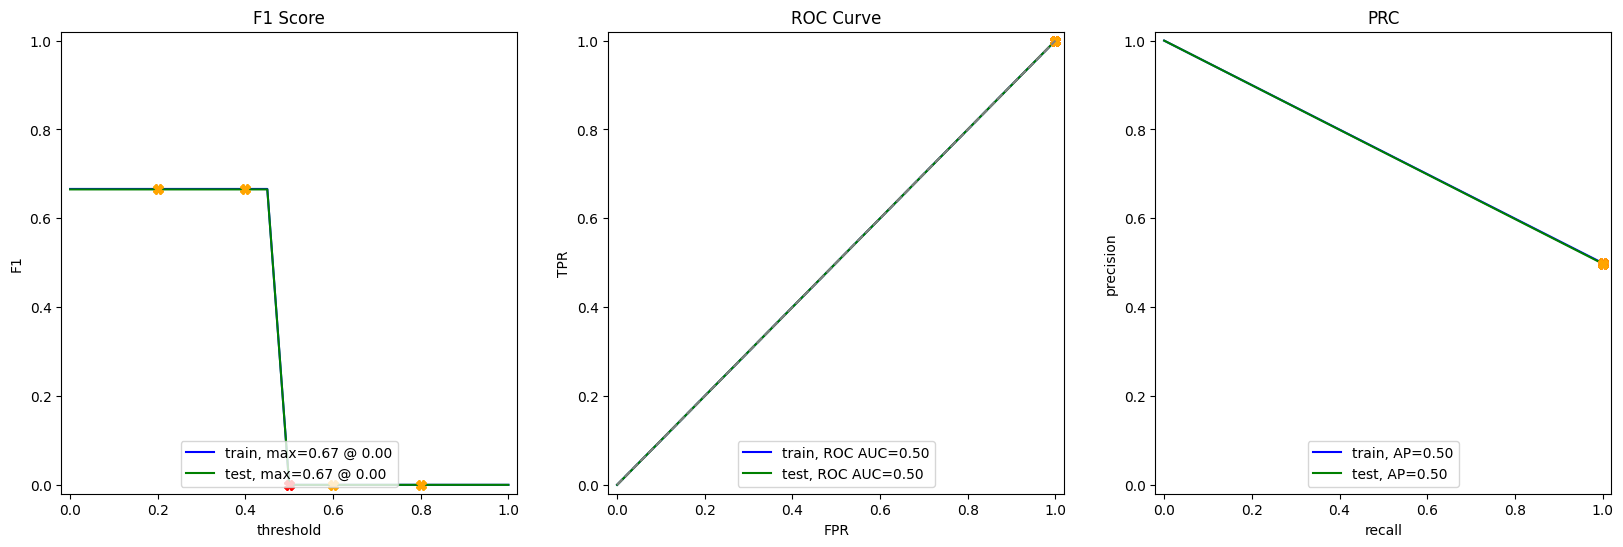

In [39]:
#Fitting model
dummy_model = DummyClassifier().fit(tfidf_corpus_train, train_target)

# Evaluating model
evaluate_model(dummy_model, tfidf_corpus_train, train_target, tfidf_corpus_test, test_target)

This dummy model returned low scores, so we will just use the **0.85 F1 score as our baseline.**

### Logistic regression

          train  test
Accuracy   0.91  0.87
F1         0.92  0.87
APS        0.97  0.94
ROC AUC    0.97  0.94


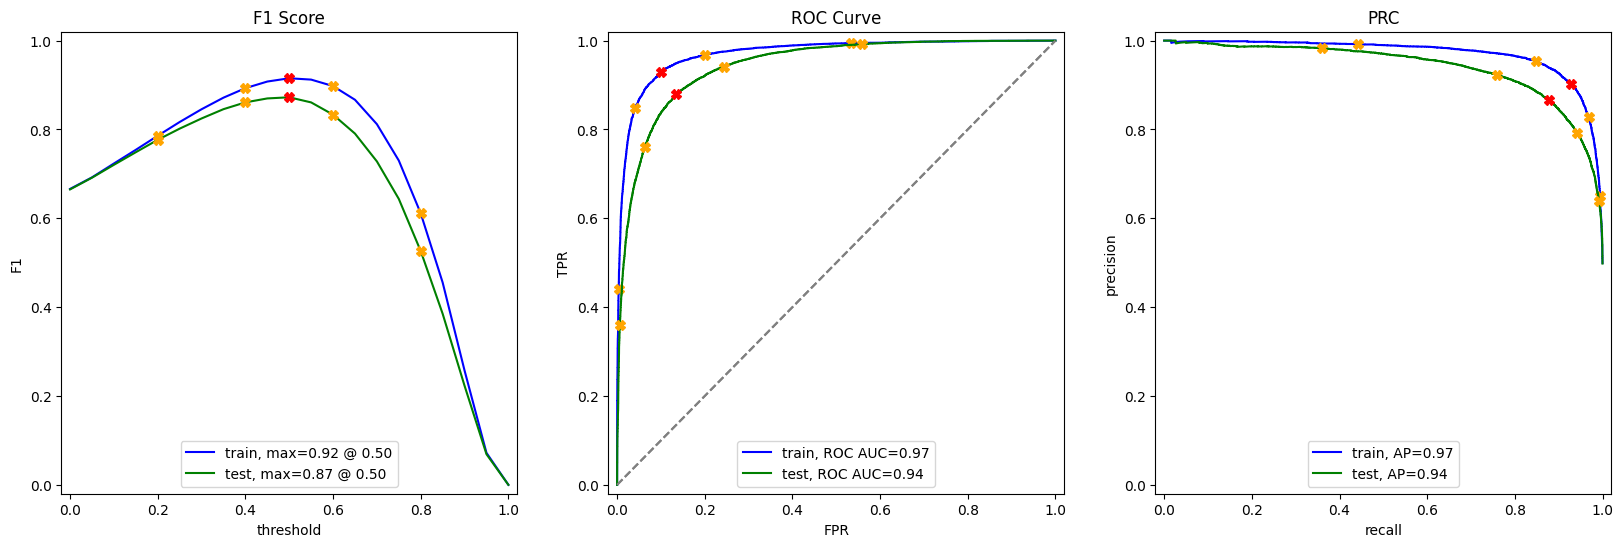

In [40]:
# Fitting model
logreg = LogisticRegression(C=0.5, random_state=random_state)
logreg.fit(tfidf_corpus_train, train_target)

# Evaluating model
evaluate_model(logreg, tfidf_corpus_train, train_target, tfidf_corpus_test, test_target)

Logistic regression did pretty well, getting **0.87** in test predictions.

### Decision tree vs. random forest

In [41]:
# Defining an objective function for Optuna
# to optimize hyperparameters of decision tree and random forest classifiers
# and cross-validate models

def objective(trial):
    x, y = tfidf_corpus_train, train_target

    classifier_name = trial.suggest_categorical("classifier", ["DecisionTree", "RandomForest"])
    if classifier_name == "DecisionTree":
        max_depth = trial.suggest_int("max_depth", 1, 15, log=True)
        classifier_obj = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
    else:
        max_depth = trial.suggest_int("max_depth", 1, 15, log=True)
        n_estimators = trial.suggest_int("n_estimators", 10, 100, log=True)
        classifier_obj = RandomForestClassifier(
            max_depth=max_depth, n_estimators=n_estimators, random_state=random_state
        )

    score = cross_val_score(classifier_obj, x, y, scoring=f1_scorer ,n_jobs=-1, cv=3)    
    score = score.mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

Optimization and cross-validation with Optuna suggested that the best model between the two was a **random forest classifier** of **`max_depth=15, n_estimators=100`**.

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=15, random_state=42)>
          train  test
Accuracy   0.90  0.83
F1         0.90  0.83
APS        0.97  0.90
ROC AUC    0.97  0.91


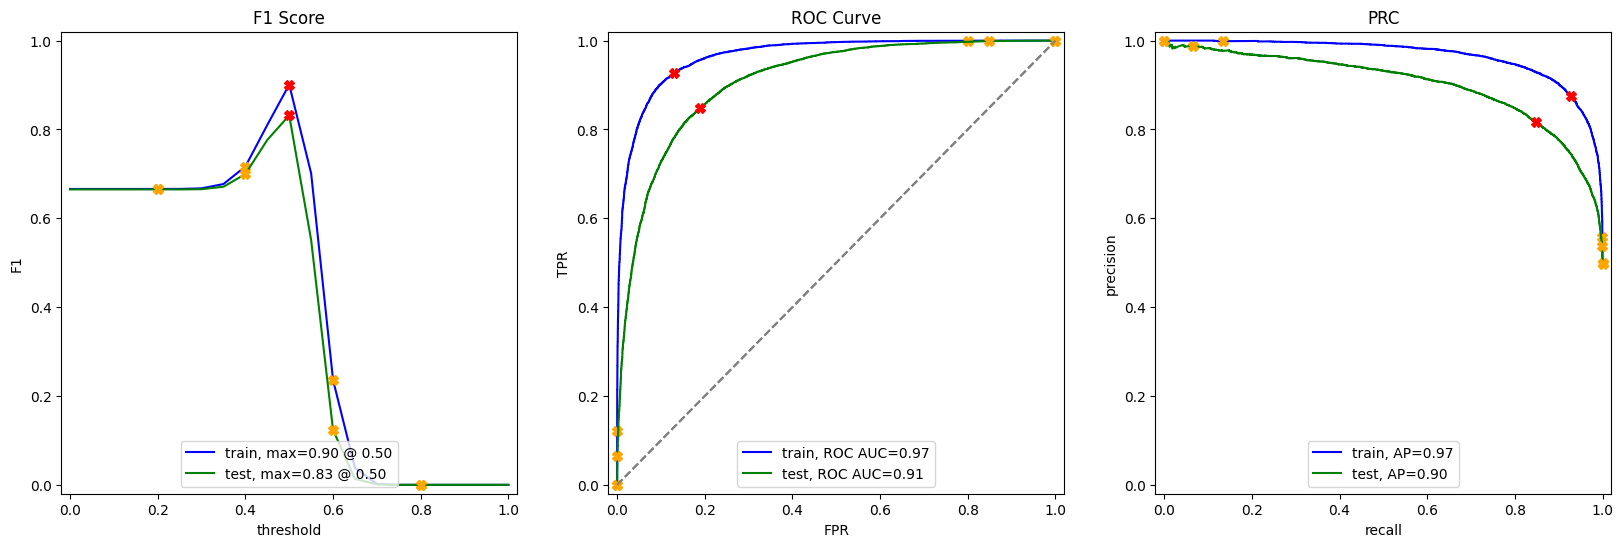

In [42]:
# Creating model based on above hyperparams
rfclassifier = RandomForestClassifier(max_depth=15, n_estimators=100, random_state=random_state)
rfclassifier.fit(tfidf_corpus_train, train_target)
print(rfclassifier.get_params)

# Evaluating the model
evaluate_model(rfclassifier, tfidf_corpus_train, train_target, tfidf_corpus_test, test_target)

With a test score of **0.83**, our random forest classifier did not pass the baseline requirement.

### XGBoost

In [43]:
def objective(trial):

#     param = {
#         "verbosity": 0,
#         "tree_method": "exact",
#         "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
#         "n_estimators": trial.suggest_int("n_estimators", 10, 100, log=True),
#         "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#     }
    """
    The method above (suggesting hyperparam values in a dict, 
    then loading it to the model as kwargs),
    which was documented in Optuna's github,
    produced a bug in which all models across all trials are trained
    with XGBoost's default hyperparam values
    instead of the suggested values.
    
    A workaround is to use the code below:
    suggesting the values directly as arguments
    during model creation.
    """

    model = XGBClassifier(random_state=random_state, verbosity=0, tree_method="exact", 
                          max_depth=(trial.suggest_int("max_depth", 3, 9, step=2)),
                          n_estimators=(trial.suggest_int("n_estimators", 10, 100, log=True)),
                          min_child_weight=(trial.suggest_int("min_child_weight", 2, 10)),
                          subsample=(trial.suggest_float("subsample", 0.2, 1.0)),
                          colsample_bytree=(trial.suggest_float("colsample_bytree", 0.2, 1.0)))
    model.fit(tfidf_corpus_train, train_target)
    pred = model.predict(tfidf_corpus_train)
    score = f1_score(train_target, pred)
    print(model.get_xgb_params())
    print(score, '----------------')
    return score


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    # n_trials decreased to 10 to save time
    study.optimize(objective, n_trials=10, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

10 Optuna trials suggested the following hyperparameters as the best:
- max_depth: 3
- n_estimators: 27
- min_child_weight: 3
- subsample: 0.34597670868744757
- colsample_bytree: 0.6969215623528796

          train  test
Accuracy   0.80  0.80
F1         0.82  0.81
APS        0.88  0.87
ROC AUC    0.89  0.88


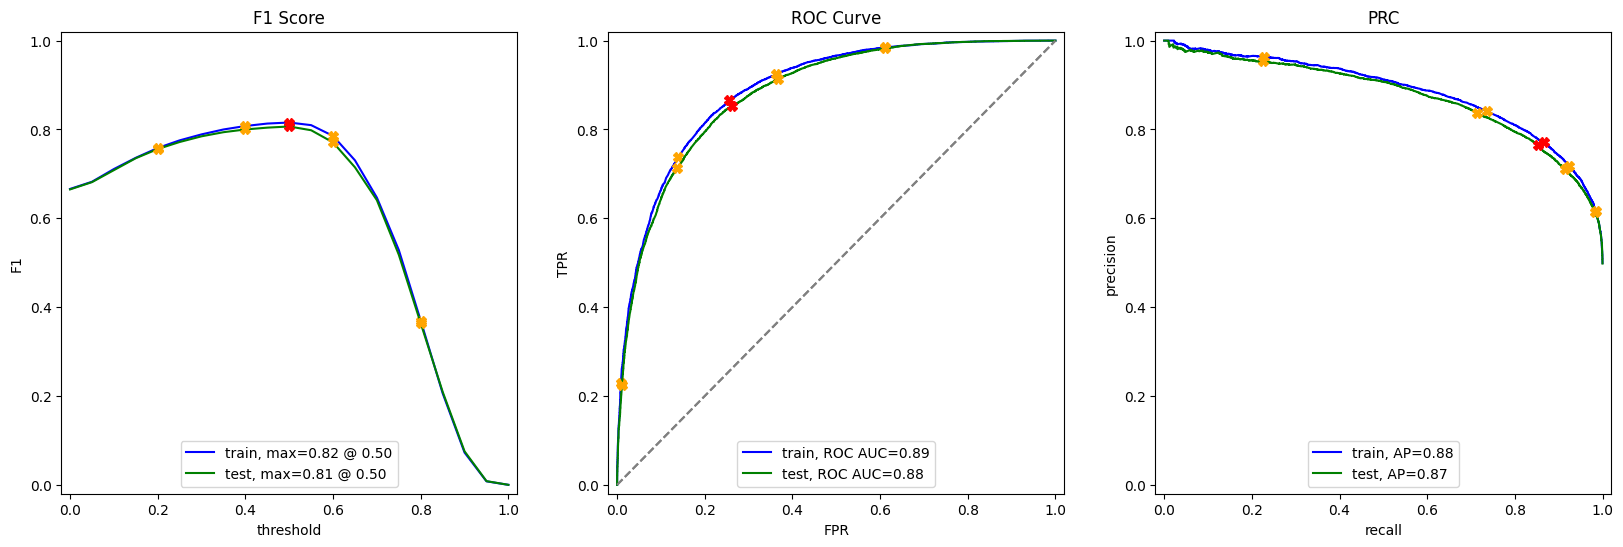

In [44]:
# Creating model based on above hyperparams
xgbc = XGBClassifier(max_depth=3, n_estimators=27, min_child_weight=3, 
            subsample=0.34597670868744757, 
            colsample_bytree=0.6969215623528796, 
            random_state=random_state)

xgbc.fit(tfidf_corpus_train, train_target)

# Evaluating the model
evaluate_model(xgbc, tfidf_corpus_train, train_target, tfidf_corpus_test, test_target)

### LightGBM

In [45]:
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "random_state": random_state
    }

    model = LGBMClassifier(**params)
    model.fit(tfidf_corpus_train, train_target)
    pred = model.predict(tfidf_corpus_train)
    score = f1_score(train_target, pred)
    return score


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

The best hyperparameters for LGBMClassifier obtained from 10 Optuna trials are:
- lambda_l1: 0.7419025662133542
- lambda_l2: 0.27207687025419436
- num_leaves: 120
- feature_fraction: 0.6204258106176211
- bagging_fraction: 0.6321814775543736
- bagging_freq: 2
- min_child_samples: 19

[LightGBM] [Warning] feature_fraction is set=0.6204258106176211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6204258106176211
[LightGBM] [Warning] bagging_fraction is set=0.6321814775543736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6321814775543736
[LightGBM] [Warning] lambda_l1 is set=0.7419025662133542, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7419025662133542
[LightGBM] [Warning] lambda_l2 is set=0.27207687025419436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.27207687025419436
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
          train  test
Accuracy   0.98  0.86
F1         0.98  0.86
APS        1.00  0.93
ROC AUC    1.00  0.94


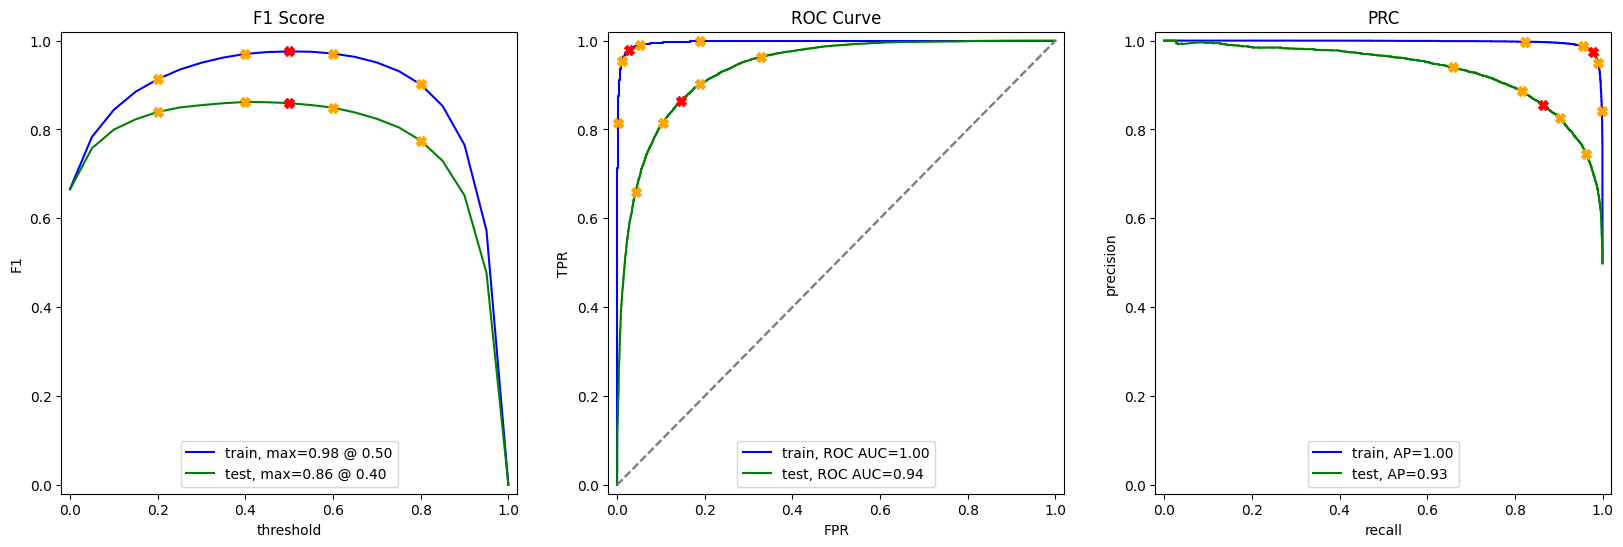

In [46]:
# Creating model based on above hyperparams
lgbmc = LGBMClassifier(lambda_l1=0.7419025662133542,
                        lambda_l2=0.27207687025419436, 
                        num_leaves=120, 
                        feature_fraction=0.6204258106176211, 
                        bagging_fraction=0.6321814775543736, 
                        bagging_freq=2, 
                        min_child_samples=19, 
                        random_state=random_state)

lgbmc.fit(tfidf_corpus_train, train_target)

# Evaluating the model
evaluate_model(lgbmc, tfidf_corpus_train, train_target, tfidf_corpus_test, test_target)

Our LGBClassifier barely passed the baseline score: **0.86**.

## Testing with self-written reviews

As a final check, we will write our own reviews and see if the models can predict their classes correctly.

Review text:
1. `what a great movie i cried tears of joy when i saw leo on screen his acting was so fantastic and deserved two oscars the supporting actors also did their best and you can feel their emotion best movie ever certainly would recommend` (positive review)
1. `as always nolan created another masterpiece this movie was not only a work of art but also a scientific work everything was so perfect the cast the plot and the soundtrack gave me chills i will definitely watch again when the blu-ray version gets released` (positive review)
1. `i walked out of the theatre halfway through the movie it was not worth the bucks the dialogues were boring and the camera angles were very awkward not to mention the cheesy jokes zero stars out of ten` (negative review)
1. `this movie is unbelievably overrated what's so good about a cliche adventure where the hero fulfills the prophecy and saves the princess it's so unoriginal and shallow it does not deserve its popularity at all save your time and watch something else` (negative review)

### Creating dataset

In [47]:
# Creating feature dict
self_reviews_dict = {
    0: "what a great movie i cried tears of joy when i saw leo on screen his acting was so fantastic and deserved two oscars the supporting actors also did their best and you can feel their emotion best movie ever certainly would recommend",
    1: "as always nolan created another masterpiece this movie was not only a work of art but also a scientific work everything was so perfect the cast the plot and the soundtrack gave me chills i will definitely watch again when the blu-ray version gets released",
    2: "i walked out of the theatre halfway through the movie it was not worth the bucks the dialogues were boring and the camera angles were very awkward not to mention the cheesy jokes zero stars out of ten",
    3: "this movie is unbelievably overrated what's so good about a cliche adventure where the hero fulfills the prophecy and saves the princess it's so unoriginal and shallow it does not deserve its popularity at all save your time and watch something else"
}
    
# Creating target dict
self_reviews_pos = [1, 1, 0, 0]
    
# Creating dataframe
self_reviews = pd.DataFrame.from_dict(data=self_review_dict, orient='index', columns=['review'])
self_reviews

,review
0,what a great movie i cried tears of joy when i...
1,as always nolan created another masterpiece th...
2,i walked out of the theatre halfway through th...
3,this movie is unbelievably overrated what's so...


### Text preprocessing

In [50]:
# Tokenization and lemmatization with previously defined spacy function
corpus_self_reviews = self_reviews['review'].apply(
        lambda row: spacy_reviews(text=row)
        )

# TF-IDF vectorization with previously fitted vectorizer
tfidf_self_reviews = tfidf.transform(corpus_self_reviews)

### ML prediction

#### Logistic regression

In [58]:
pred = logreg.predict(tfidf_self_reviews)
print('Predictions:', pred)
f1_score(self_reviews_pos, pred)

Predictions: [1 1 0 0]


1.0

#### Random forest

In [59]:
pred = rfclassifier.predict(tfidf_self_reviews)
print('Predictions:', pred)
f1_score(self_reviews_pos, pred)

Predictions: [1 1 0 0]


1.0

#### XGBoost

In [55]:
pred = xgbc.predict(tfidf_self_reviews)
print('Predictions:', pred)
f1_score(self_reviews_pos, pred)

Predictions: [1 1 0 1]


0.8

#### LightGBM

In [57]:
pred = lgbmc.predict(tfidf_self_reviews)
print('Predictions:', pred)
f1_score(self_reviews_pos, pred)

Predictions: [1 1 0 1]


0.8

### Summary

It turned out that models with simpler algorithms predicted everything correctly, whereas gradient-boosting algorithms failed to predict the fourth review (both XGBoost and LightGBM classifiers predicted it as positive instead of negative).

## ML summary

We created 6 classifier models and got the following F1 scores for test predictions:
- Constant dummy model, for sanity check: `0.0` (which is lower than the baseline score of `0.85` anyway)
- Logistic regression: `0.87`
- Between decision tree and random forest classifiers, Optuna suggested that random forest was better. It got a test score of `0.83`.
- XGBoost: `0.81`
- LightGBM: `0.86`

Only logistic regression and LGBM classifier passed the minimum requirement.

We also wrote our own reviews and had our models predict their classes. Logistic regression and random forest predicted all classes correctly, while gradient-boosting models failed to predict the negativity of the last review.

Based on these experiments, **logistic regression (F1: 0.87) would be the best** model for this job.

# Conclusion

We were given a set of 47331 reviews. We dropped all irrelevant features, getting only `review`,`pos`, and `ds_part` columns. 90 of these reviews were duplicates, so we dropped them.

In EDA, we found that the target classes were balanced.

In preprocessing, we did the following:
- normalization: removing all non-letter and non-whitespace characters, except for apostrophes.
- set separation: separating the whole dataset into train and test sets with values in `pos` as a reference.
- tokenization & lemmatization: we used spaCy to split whole reviews into lemmas.
- vectorization: converting lemmas (except stop words) into numerical, unigram vectors using a TF-IDF vectorizer.

In ML, we did the following steps:
- defining a routine to evaluate models
- created, tuned, trained, and evaluated 6 classification models:
	- constant dummy classifier
	- logistic regression
	- decision tree
	- random forest
	- XGBoost
	- LightGBM

Hyperparameter tuning, where applicable, were conducted with Optuna.

Of all models, only logistic regression and LGBM classifier passed the **minimum requirement of F1 0.85**, and **logistic regression (F1: 0.87)** was the best between the two.

We also wrote our own reviews and had our models predict their classes. Logistic regression and random forest predicted all classes correctly, while gradient-boosting models failed to predict the negativity of the last review.

In conclusion, the best model for Film Junky Union would be our **logistic regression** model, trained with our dataset.

_Please note that actual data need to be processed using the same procedures we used in this project for the model to work properly._